In [49]:
# Dataset Setup section:
from datasets import load_dataset
import pandas as pd

# Load the full dataset from Hugging Face
dataset = load_dataset("TrainingDataPro/customers-reviews-on-banks")

# Extract the targeted variables from the 'train' split
df = dataset['train'].to_pandas()[['bank', 'star', 'text']]

In [50]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import pandas as pd
import re
from collections import Counter

In [53]:
# ----- Data Preparation -----
df = df[df["text"].notna() & df["star"].notna()]  # clean nulls

In [55]:
def map_star_to_sentiment(star): #mapping from star to different levels 1,2,3
    if star <= 2: return 0
    elif star == 3: return 1
    else: return 2

In [57]:
df["label"] = df["star"].apply(map_star_to_sentiment)

In [59]:
def tokenize(text):
    return re.sub(r"[^\w\s]", "", text.lower()).split()

In [61]:
# Build vocabulary from tokenized text data
all_tokens = [token for text in df["text"] for token in tokenize(text)]

# Create a vocabulary: assign a unique index to each token
# Start indexing from 2 to reserve 0 and 1 for special tokens
vocab = {t: i+2 for i, (t, _) in enumerate(Counter(all_tokens).items())}
# Add special tokens to the vocabulary
vocab["<pad>"] = 0
vocab["<unk>"] = 1

#Convert text to fixed-length sequences of token IDs
def text_to_seq(text, max_len=100):
    ids = [vocab.get(t, 1) for t in tokenize(text)][:max_len]
    return ids + [0]*(max_len - len(ids))
    
#Create a custom PyTorch dataset class
class ReviewDataset(Dataset):
    
    def __init__(self, texts, labels):
        self.texts = texts # List of review texts
        self.labels = labels# Corresponding list of sentiment labels
        
    def __len__(self): return len(self.texts)   # Total number of samples
    def __getitem__(self, i):
        x = torch.tensor(text_to_seq(self.texts[i])) 
        y = torch.tensor(self.labels[i]) # Target label
        return x, y

In [63]:
#  Split dataset into training and testing sets (80/20 ratio)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

#Create custom Dataset instances for training and testing sets
train_ds = ReviewDataset(train_df["text"].tolist(), train_df["label"].tolist())
test_ds = ReviewDataset(test_df["text"].tolist(), test_df["label"].tolist())
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

In [65]:
#Define LSTM-based classifier for sentiment analysis
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128, output_dim=3):
        super().__init__()
        #Converts token IDs into dense vector
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        #Processes sequences of embeddings
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        #Maps LSTM output to class scores (e.g., 3 sentiment classes)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(len(vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#Define loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

In [67]:
#Track training loss for each epoch
loss_history = []

for epoch in range(30): #Train for 30 epochs
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad() #Reset gradients
        loss = criterion(model(x), y)  # Compare to true labels
        loss.backward()
        optimizer.step() # Update model weights
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader) #Compute average loss for this epoch
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

Epoch 1: Loss = 0.3421
Epoch 2: Loss = 0.2149
Epoch 3: Loss = 0.1664
Epoch 4: Loss = 0.1339
Epoch 5: Loss = 0.1105
Epoch 6: Loss = 0.0872
Epoch 7: Loss = 0.0697
Epoch 8: Loss = 0.0562
Epoch 9: Loss = 0.0472
Epoch 10: Loss = 0.0392
Epoch 11: Loss = 0.0310
Epoch 12: Loss = 0.0242
Epoch 13: Loss = 0.0234
Epoch 14: Loss = 0.0197
Epoch 15: Loss = 0.0162
Epoch 16: Loss = 0.0135
Epoch 17: Loss = 0.0121
Epoch 18: Loss = 0.0164
Epoch 19: Loss = 0.0103
Epoch 20: Loss = 0.0098
Epoch 21: Loss = 0.0113
Epoch 22: Loss = 0.0092
Epoch 23: Loss = 0.0081
Epoch 24: Loss = 0.0045
Epoch 25: Loss = 0.0085
Epoch 26: Loss = 0.0066
Epoch 27: Loss = 0.0060
Epoch 28: Loss = 0.0024
Epoch 29: Loss = 0.0011
Epoch 30: Loss = 0.0009


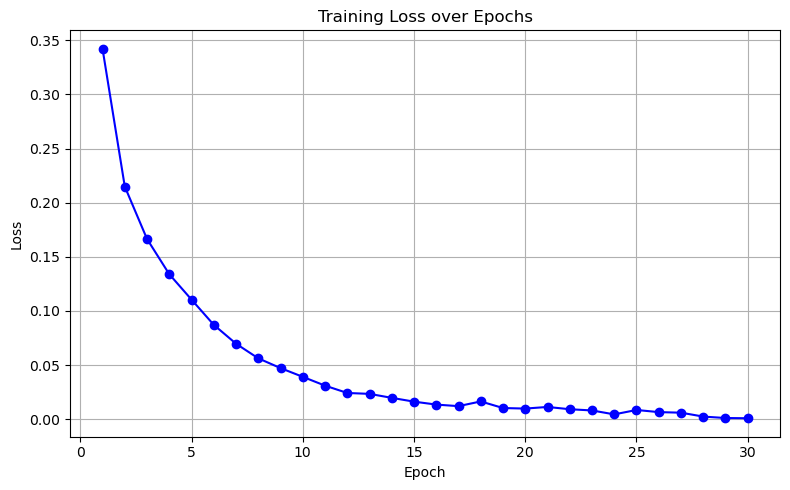

In [71]:
import matplotlib.pyplot as plt

#Plot training loss over 30 epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, 31), loss_history, marker='o', linestyle='-', color='blue')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True) #Add grid and customize x-axis ticks
plt.xticks(range(0, 31, 5))  # tick every 5 epochs
plt.tight_layout()
plt.show()

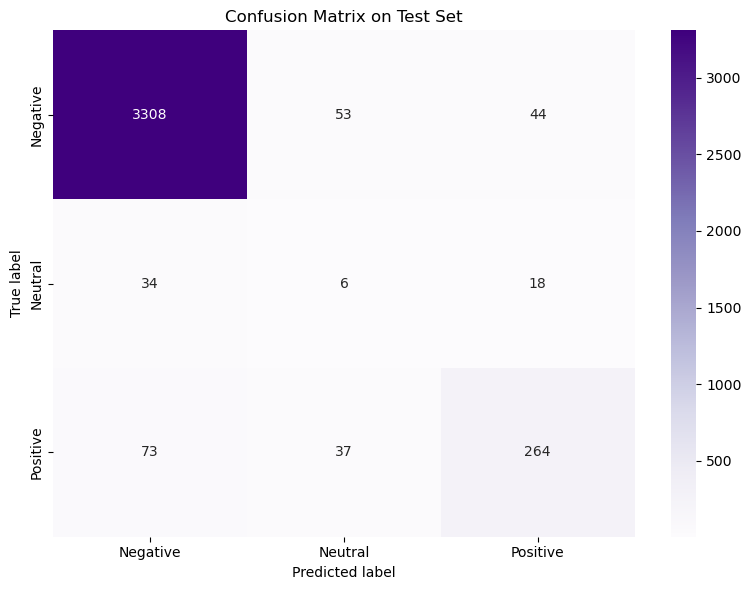

In [129]:
#Using a confusion matrix to evaluate classification performance
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred are defined
cm = confusion_matrix(y_true, y_pred) #Compute confusion matrix
labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(8, 6)) #Plot heatmap of confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


In [113]:
#Prediction on Test Set
def predict_sentiment(texts):
    model.eval() # Set model to evaluation mode
    preds = []   # To store predicted class labels
    with torch.no_grad(): # Disable gradient
        for t in texts:
              # Convert text to padded sequence of token IDs
            x = torch.tensor(text_to_seq(t)).unsqueeze(0).to(device)
            y_hat = model(x)
            # Get index of highest score (predicted class)
            pred = torch.argmax(y_hat, dim=1).item()
            preds.append(pred)
    return preds
#Add predicted sentiment labels to test dataframe
test_df = test_df.copy()
test_df["predicted_sentiment"] = predict_sentiment(test_df["text"].tolist())

In [137]:

# Aggregation by Bank 
summary = test_df.groupby("bank")["predicted_sentiment"].value_counts().unstack().fillna(0)
summary.columns = ["negative", "neutral", "positive"]
summary["total"] = summary.sum(axis=1)
summary["positive_ratio"] = summary["positive"] / summary["total"]
summary["negative_ratio"] = summary["negative"] / summary["total"]

#Top 5 / Bottom 5 summary
from tabulate import tabulate
bottom_5 = summary.sort_values(
    by=["negative_ratio", "negative"],
    ascending=[False, False]  # sort both in descending order
).head(5)

#top 5:
top_5 = summary.sort_values("positive_ratio", ascending=False).head(5)
print("Top 5 Banks by Positive Sentiment Ratio:")
print(tabulate(top_3.reset_index()[["bank", "positive", "neutral", "negative", "positive_ratio"]],
               headers="keys", tablefmt="fancy_grid"))

# Bottom 5 Table 
print("Bottom 5 Banks by Negative Sentiment Ratio:")
print(tabulate(bottom_5.reset_index()[["bank", "negative", "neutral", "positive", "negative_ratio"]],
               headers="keys", tablefmt="fancy_grid"))


Top 5 Banks by Positive Sentiment Ratio:
╒════╤═══════════════════════════╤════════════╤═══════════╤════════════╤══════════════════╕
│    │ bank                      │   positive │   neutral │   negative │   positive_ratio │
╞════╪═══════════════════════════╪════════════╪═══════════╪════════════╪══════════════════╡
│  0 │ bmo-harris-bank           │          1 │         0 │          0 │         1        │
├────┼───────────────────────────┼────────────┼───────────┼────────────┼──────────────────┤
│  1 │ merrick_bank              │        141 │        15 │         74 │         0.613043 │
├────┼───────────────────────────┼────────────┼───────────┼────────────┼──────────────────┤
│  2 │ arrowhead_credit_union_ca │          2 │         0 │          2 │         0.5      │
├────┼───────────────────────────┼────────────┼───────────┼────────────┼──────────────────┤
│  3 │ armed_forces_bank         │          1 │         1 │          5 │         0.142857 │
├────┼───────────────────────────┼─────

In [143]:
#Produce the actual result using the 20% testing dataset based on Star Ratings: 

from tabulate import tabulate

# ----- Star Rating Analysis on Test Set -----

# Categorize the original star rating
def categorize_star_rating(star):
    if star in [1, 2]:
        return 'poor'
    elif star == 3:
        return 'neutral'
    elif star in [4, 5]:
        return 'good'
    else:
        return 'unknown'

test_df["rating_category"] = test_df["star"].apply(categorize_star_rating)

# Group by bank
star_summary = test_df.groupby("bank").agg(
    review_count=('star', 'count'),
    poor_reviews=('rating_category', lambda x: (x == 'poor').sum()),
    neutral_reviews=('rating_category', lambda x: (x == 'neutral').sum()),
    good_reviews=('rating_category', lambda x: (x == 'good').sum())
)

# Calculate good_ratio and negative_ratio
star_summary["positive_ratio"] = star_summary["good_reviews"] / star_summary["review_count"]
star_summary["negative_ratio"] = star_summary["poor_reviews"] / star_summary["review_count"]

# Top 5 by positive ratio
top_5_star = star_summary.sort_values("positive_ratio", ascending=False).head(5)

# Bottom 5 by negative ratio (with tie-breaker)
bottom_5_star = star_summary.sort_values(
    by=["negative_ratio", "poor_reviews"],
    ascending=[False, False]
).head(5)

# Print star-based ranking tables
print("Top 5 Banks by Positive Star Rating Ratio:")
print(tabulate(top_3_star.reset_index()[["bank", "good_reviews", "neutral_reviews", "poor_reviews", "positive_ratio"]],
               headers="keys", tablefmt="fancy_grid"))

print("Bottom 5 Banks by Negative Star Rating Ratio:")
print(tabulate(bottom_5_star.reset_index()[["bank", "poor_reviews", "neutral_reviews", "good_reviews", "negative_ratio"]],
               headers="keys", tablefmt="fancy_grid"))


Top 5 Banks by Positive Star Rating Ratio:
╒════╤═══════════════════════════╤════════════════╤═══════════════════╤════════════════╤══════════════════╕
│    │ bank                      │   good_reviews │   neutral_reviews │   poor_reviews │   positive_ratio │
╞════╪═══════════════════════════╪════════════════╪═══════════════════╪════════════════╪══════════════════╡
│  0 │ bmo-harris-bank           │              1 │                 0 │              0 │         1        │
├────┼───────────────────────────┼────────────────┼───────────────────┼────────────────┼──────────────────┤
│  1 │ arrowhead_credit_union_ca │              3 │                 0 │              1 │         0.75     │
├────┼───────────────────────────┼────────────────┼───────────────────┼────────────────┼──────────────────┤
│  2 │ merrick_bank              │            145 │                16 │             69 │         0.630435 │
├────┼───────────────────────────┼────────────────┼───────────────────┼────────────────┼─────